## Homework 4. Evaluation.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

#### Preparation

In [2]:
df = pd.read_csv("AER_credit_card_data.csv")
df.head(4)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.54,0.065214,137.869200,no,no,0,25,1,7


In [3]:
# df.info()

In [4]:
df.card = df.card.map({"yes": 1, "no": 0})

Split the data

In [5]:
y = df.card
del df["card"]
X = df

In [6]:
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
    )

X_train,  X_val, y_train, y_val = train_test_split(
    X_full_train, y_full_train, test_size=0.25, random_state=1
    )

len(y_train), len(y_test), len(y_val)

(791, 264, 264)

### Question 1. Single factor analysis

In [7]:
for column in list(X_train.select_dtypes("number")):
    score = roc_auc_score(y_train, X_train[column])
    print(f"{column} score: {score:.3f}")

reports score: 0.283
age score: 0.476
income score: 0.591
share score: 0.989
expenditure score: 0.991
dependents score: 0.467
months score: 0.471
majorcards score: 0.534
active score: 0.604


Select columns below and use DictVectorizer

In [8]:
selected = [
    "reports", 
    "age", 
    "income", 
    "share", 
    "expenditure", 
    "dependents", 
    "months", 
    "majorcards", 
    "active", 
    "owner", 
    "selfemp"
]

In [9]:
dv = DictVectorizer(sparse=False)

In [10]:
x_train_dict = X_train[selected].to_dict(orient="records")
X_train_dv = dv.fit_transform(x_train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Question 2. Validation AUC

In [11]:
x_val_dict = X_val[selected].to_dict(orient="records")
X_val_dv = dv.transform(x_val_dict)

y_pred = model.predict_proba(X_val_dv)[:, 1]
roc_auc_score(y_val, y_pred).round(3)

0.995

### Question 3. Precision & Recall

In [12]:
### scikit-learn precision_recall

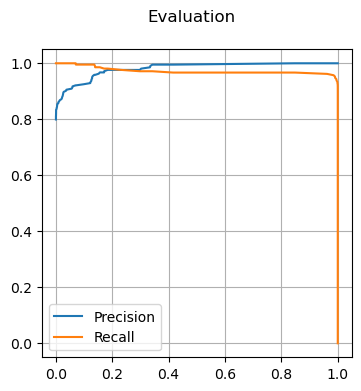

In [13]:
precision, recall, thresholds = precision_recall_curve(y_true=y_val, probas_pred=y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot([0]+list(thresholds), precision, label="Precision")
ax.plot([0]+list(thresholds), recall, label="Recall")
plt.legend()
plt.suptitle("Evaluation")
plt.grid()
plt.show()

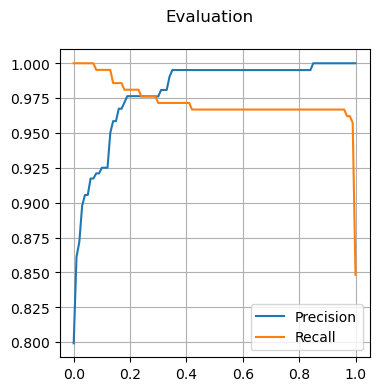

In [14]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
total_positive = actual_positive.sum()
thresholds = np.arange(1.01, step=0.01)
precision = []
recall = []
F1_score = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    # tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    # fn = (predict_negative & actual_positive).sum()
    
    prec = tp / (tp + fp)
    # rec = tp / (tp + fn)
    rec = tp / total_positive
    precision.append(prec)
    recall.append(rec)
    F1_score.append(2 * prec * rec / (prec + rec))
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(thresholds, precision, label="Precision")
ax.plot(thresholds, recall, label="Recall")
plt.legend()
plt.suptitle("Evaluation")
plt.grid()
plt.show()

In [15]:
max(thresholds[np.asarray(precision) == np.asarray(recall)]).round(1)

0.3

### Question 4. $F_1$ score

In [16]:
F1_max = max(F1_score)
F1_max

0.9832134292565947

In [17]:
thresholds[F1_score.index(F1_max)].round(1)

0.4

Create pipeline for cross-validation

In [18]:
cvs_list = []
params = [0.01, 0.1, 1, 10]
for C in params:
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    steps = [
        (
            "dv", 
            DictVectorizer(sparse=False)
        ), 
        (
            "logit", 
            LogisticRegression(
                solver='liblinear', 
                C=C, 
                max_iter=1000
            )
        )
    ]
    logit_pipeline = Pipeline(steps)
### calculate AUCs
    cvs = cross_val_score(
        estimator=logit_pipeline, 
        X=X_full_train[selected].to_dict(orient="records"), 
        y=y_full_train, 
        cv=cv,
        scoring="roc_auc"
    )
    cvs_list.append(cvs)

### Question 5. KFold

In [19]:
cvs_list[2].std().round(3)

0.003

### Question 6. Best penalty

In [20]:
Results = pd.DataFrame(dict(zip(params, cvs_list)))
Results

,0.01,0.10,1.00,10.00
0,0.984219,0.990033,0.994186,0.993494
1,0.987500,0.991422,0.994118,0.994240
2,0.992227,0.994862,0.994335,0.994598
3,0.995459,0.998962,0.999611,0.999611
4,1.000000,1.000000,1.000000,1.000000


In [21]:
Results.mean()

0.01     0.991881
0.10     0.995056
1.00     0.996450
10.00    0.996389
dtype: float64